In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
# from smac.env import StarCraft2Env
import argparse
from replay_buffer import ReplayBuffer
from qmix_smac import QMIX_SMAC
from normalization import Normalization
import sys
import matplotlib.pyplot as plt
import captain
import gym
import time
import random
from os import replace
from absl import logging
from smacv2.env.starcraft2.wrapper import StarCraftCapabilityEnvWrapper
logging.set_verbosity(logging.DEBUG)

In [2]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


# Out of Box

In [6]:
class Runner_QMIX_SMAC:
    def __init__(self, args, number, seed):
        self.args = args
        self.number = number
        self.seed = seed
        # Set random seed
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        # Create env
        self.distribution_config = {
                        "n_units": self.args.N_agents,
                        "team_gen": {
                            "dist_type": "weighted_teams",
                            "unit_types": ["marine", "marauder", "medivac"],
                            "exception_unit_types": ["medivac"],
                            "weights": [1, 0, 0],
                            "observe": True,
                        },
                        "start_positions": {
                            "dist_type": "surrounded_and_reflect",
                            "p": 0.5,
                            "map_x": 32,
                            "map_y": 32,
                        },
                        "n_enemies": self.args.N_agents,
                    }
        self.env = StarCraftCapabilityEnvWrapper(
                    capability_config=self.distribution_config,
                    map_name="10gen_terran",
                    debug=False,
                    conic_fov=False,
                    obs_own_pos=True,
                    use_unit_ranges=False,
                    min_attack_range=2,
                    seed = self.seed)
        
        self.env_info = self.env.get_env_info()
        self.args.N = self.env_info["n_agents"]  # The number of agents
        self.args.obs_dim = self.env_info["obs_shape"]  # The dimensions of an agent's observation space
        self.args.state_dim = self.env_info["state_shape"]  # The dimensions of global state space
        self.args.action_dim = self.env_info["n_actions"]  # The dimensions of an agent's action space
        self.args.episode_limit = self.env_info["episode_limit"]  # Maximum number of steps per episode
        print("number of agents={}".format(self.args.N))
        print("obs_dim={}".format(self.args.obs_dim))
        print("state_dim={}".format(self.args.state_dim))
        print("action_dim={}".format(self.args.action_dim))
        print("episode_limit={}".format(self.args.episode_limit))

        # Create N agents
        self.agent_n = QMIX_SMAC(self.args)
        self.replay_buffer = ReplayBuffer(self.args)
        # Create a tensorboard
        
        
        self.epsilon = self.args.epsilon  # Initialize the epsilon
        self.win_rates = []  # Record the win rates
        self.total_steps = 0
        if self.args.use_reward_norm:
            print("------use reward norm------")
            self.reward_norm = Normalization(shape=1)

    def run(self, ):
        evaluate_num = -1  # Record the number of evaluations
        while self.total_steps < self.args.max_train_steps:
            if self.total_steps // self.args.evaluate_freq > evaluate_num:
                self.evaluate_policy()  # Evaluate the policy every 'evaluate_freq' steps
                evaluate_num += 1

            _, _, episode_steps = self.run_episode_smac(evaluate=False)  # Run an episode
            self.total_steps += episode_steps

            if self.replay_buffer.current_size >= self.args.batch_size:
                self.agent_n.train(self.replay_buffer, self.total_steps)  # Training

        self.evaluate_policy()
        self.env.close()

    def evaluate_policy(self, ):
        win_times = 0
        evaluate_reward = 0
        for _ in range(self.args.evaluate_times):
            win_tag, episode_reward, _ = self.run_episode_smac(evaluate=True)
            if win_tag:
                win_times += 1
            evaluate_reward += episode_reward

        win_rate = win_times / self.args.evaluate_times
        evaluate_reward = evaluate_reward / self.args.evaluate_times
        self.win_rates.append(win_rate)
        print("total_steps:{} \t win_rate:{} \t evaluate_reward:{}".format(self.total_steps, win_rate, evaluate_reward))
        
        # Save the win rates
        np.save('./data_train/{}_env_{}_number_{}_seed_{}.npy'.format(self.args.algorithm, self.env_name, self.number, self.seed), np.array(self.win_rates))

    def run_episode_smac(self, evaluate=False):
        win_tag = False
        episode_reward = 0
        self.env.reset()
        if self.args.use_rnn:  # If use RNN, before the beginning of each episode，reset the rnn_hidden of the Q network.
            self.agent_n.eval_Q_net.rnn_hidden = None
        last_onehot_a_n = np.zeros((self.args.N, self.args.action_dim))  # Last actions of N agents(one-hot)
        for episode_step in range(self.args.episode_limit):
            obs_n = self.env.get_obs()  # obs_n.shape=(N,obs_dim)
            s = self.env.get_state()  # s.shape=(state_dim,)
            avail_a_n = self.env.get_avail_actions()  # Get available actions of N agents, avail_a_n.shape=(N,action_dim)
            epsilon = 0 if evaluate else self.epsilon
            a_n = self.agent_n.choose_action(obs_n, last_onehot_a_n, avail_a_n, epsilon)
            last_onehot_a_n = np.eye(self.args.action_dim)[a_n]  # Convert actions to one-hot vectors
            r, done, info = self.env.step(a_n)  # Take a step
            win_tag = True if done and 'battle_won' in info and info['battle_won'] else False
            episode_reward += r

            if not evaluate:
                if self.args.use_reward_norm:
                    r = self.reward_norm(r)
                """"
                    When dead or win or reaching the episode_limit, done will be Ture, we need to distinguish them;
                    dw means dead or win,there is no next state s';
                    but when reaching the max_episode_steps,there is a next state s' actually.
                """
                if done and episode_step + 1 != self.args.episode_limit:
                    dw = True
                else:
                    dw = False

                # Store the transition
                self.replay_buffer.store_transition(episode_step, obs_n, s, avail_a_n, last_onehot_a_n, a_n, r, dw)
                # Decay the epsilon
                self.epsilon = self.epsilon - self.args.epsilon_decay if self.epsilon - self.args.epsilon_decay > self.args.epsilon_min else self.args.epsilon_min

            if done:
                break

        if not evaluate:
            # An episode is over, store obs_n, s and avail_a_n in the last step
            obs_n = self.env.get_obs()
            s = self.env.get_state()
            avail_a_n = self.env.get_avail_actions()
            self.replay_buffer.store_last_step(episode_step + 1, obs_n, s, avail_a_n)

        return win_tag, episode_reward, episode_step + 1


## Base 

### sight 12,  5e5 setps,  10 marines

In [4]:
max_train_steps = int(5e5)
evaluate_freq = max_train_steps//20
epsilon_decay_steps = max_train_steps*1//5

parser = argparse.ArgumentParser("Hyperparameter Setting for QMIX and VDN in SMAC environment")
parser.add_argument("--max_train_steps", type=int, default=max_train_steps, help=" Maximum number of training steps")
parser.add_argument("--evaluate_freq", type=float, default=evaluate_freq, help="Evaluate the policy every 'evaluate_freq' steps")
parser.add_argument("--evaluate_times", type=float, default=100, help="Evaluate times")
parser.add_argument("--save_freq", type=int, default=int(1e5), help="Save frequency")

parser.add_argument("--algorithm", type=str, default="QMIX", help="QMIX or VDN")
parser.add_argument("--epsilon", type=float, default=1.0, help="Initial epsilon")
parser.add_argument("--epsilon_decay_steps", type=float, default=epsilon_decay_steps, help="How many steps before the epsilon decays to the minimum")
parser.add_argument("--epsilon_min", type=float, default=0.05, help="Minimum epsilon")
parser.add_argument("--buffer_size", type=int, default=5000, help="The capacity of the replay buffer")
parser.add_argument("--batch_size", type=int, default=32, help="Batch size (the number of episodes)")
parser.add_argument("--lr", type=float, default=5e-4, help="Learning rate")
parser.add_argument("--gamma", type=float, default=0.99, help="Discount factor")
parser.add_argument("--qmix_hidden_dim", type=int, default=32, help="The dimension of the hidden layer of the QMIX network")
parser.add_argument("--hyper_hidden_dim", type=int, default=64, help="The dimension of the hidden layer of the hyper-network")
parser.add_argument("--hyper_layers_num", type=int, default=1, help="The number of layers of hyper-network")
parser.add_argument("--rnn_hidden_dim", type=int, default=64, help="The dimension of the hidden layer of RNN")
parser.add_argument("--mlp_hidden_dim", type=int, default=64, help="The dimension of the hidden layer of MLP")
parser.add_argument("--use_rnn", type=bool, default=True, help="Whether to use RNN")
parser.add_argument("--use_orthogonal_init", type=bool, default=True, help="Orthogonal initialization")
parser.add_argument("--use_grad_clip", type=bool, default=True, help="Gradient clip")
parser.add_argument("--use_lr_decay", type=bool, default=False, help="use lr decay")
parser.add_argument("--use_RMS", type=bool, default=False, help="Whether to use RMS,if False, we will use Adam")
parser.add_argument("--add_last_action", type=bool, default=True, help="Whether to add last actions into the observation")
parser.add_argument("--add_agent_id", type=bool, default=False, help="Whether to add agent id into the observation")
parser.add_argument("--use_double_q", type=bool, default=True, help="Whether to use double q-learning")
parser.add_argument("--use_reward_norm", type=bool, default=False, help="Whether to use reward normalization")
parser.add_argument("--use_hard_update", type=bool, default=True, help="Whether to use hard update")
parser.add_argument("--target_update_freq", type=int, default=200, help="Update frequency of the target network")
parser.add_argument("--tau", type=int, default=0.005, help="If use soft update")
parser.add_argument("--N_agents", type=int, default=10, help="Number of agents for a team")
sys.argv=['']
args = parser.parse_args()
args.epsilon_decay = (args.epsilon - args.epsilon_min) / args.epsilon_decay_steps

env_names = ['3m', '8m', '2s3z', '25m']
env_index = 1
runner = Runner_QMIX_SMAC(args, env_name=env_names[env_index], number=1, seed=0)
runner.run()

number of agents=10
obs_dim=162
state_dim=290
action_dim=16
episode_limit=200
------add last action------
------use RNN------
------use_orthogonal_init------
------use_orthogonal_init------
------algorithm: QMIX------
hyper_layers_num=1
hyper_layers_num=1
------optimizer: Adam------


INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 1274 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-v68viwcv\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:1274/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:1274/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:1274/sc2api, attempt: 2, running: True


total_steps:0 	 win_rate:0.0 	 evaluate_reward:3.154400000000001
total_steps:25000 	 win_rate:0.09 	 evaluate_reward:7.983733333333338
total_steps:50017 	 win_rate:0.09 	 evaluate_reward:9.020533333333331


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 1296 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-4i6qlwi3\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:1296/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:1296/sc2api, attempt: 1, running: True


total_steps:75007 	 win_rate:0.09 	 evaluate_reward:8.374133333333335
total_steps:100002 	 win_rate:0.09 	 evaluate_reward:8.4512


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 1320 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-91krbvfl\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:1320/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:1320/sc2api, attempt: 1, running: True


total_steps:125020 	 win_rate:0.17 	 evaluate_reward:10.888000000000002
total_steps:150031 	 win_rate:0.18 	 evaluate_reward:11.21466666666667


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 2289 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-ollrsr_e\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:2289/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:2289/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:2289/sc2api, attempt: 2, running: True


total_steps:175029 	 win_rate:0.39 	 evaluate_reward:13.742133333333333
total_steps:200001 	 win_rate:0.29 	 evaluate_reward:12.531466666666663


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 2689 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-02u8ja2n\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:2689/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:2689/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:2689/sc2api, attempt: 2, running: True


total_steps:225007 	 win_rate:0.69 	 evaluate_reward:17.145599999999998
total_steps:250048 	 win_rate:0.69 	 evaluate_reward:16.886666666666667
total_steps:275016 	 win_rate:0.71 	 evaluate_reward:17.018933333333333


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 3130 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-kdf8l3m7\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:3130/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:3130/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:3130/sc2api, attempt: 2, running: True


total_steps:300008 	 win_rate:0.74 	 evaluate_reward:17.309066666666673
total_steps:325001 	 win_rate:0.81 	 evaluate_reward:18.16533333333333


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 3579 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-t2zu9x04\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:3579/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:3579/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:3579/sc2api, attempt: 2, running: True


total_steps:350024 	 win_rate:0.74 	 evaluate_reward:17.724000000000004
total_steps:375009 	 win_rate:0.79 	 evaluate_reward:18.153066666666668


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 4041 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-6ovk6v4o\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:4041/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:4041/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:4041/sc2api, attempt: 2, running: True


total_steps:400019 	 win_rate:0.85 	 evaluate_reward:18.645066666666665
total_steps:425033 	 win_rate:0.82 	 evaluate_reward:18.21306666666667


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 4147 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-sx6v_n4o\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:4147/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:4147/sc2api, attempt: 1, running: True


total_steps:450012 	 win_rate:0.78 	 evaluate_reward:17.71066666666667
total_steps:475017 	 win_rate:0.83 	 evaluate_reward:18.387733333333333


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 4200 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-z213cri3\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:4200/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:4200/sc2api, attempt: 1, running: True
INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1


total_steps:500038 	 win_rate:0.78 	 evaluate_reward:17.9152


In [4]:
import numpy as np
import matplotlib.pyplot as plt

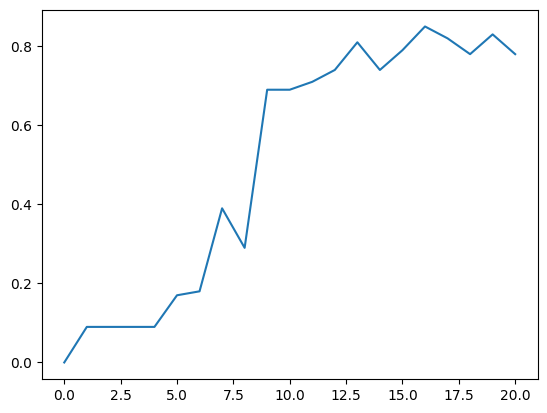

In [5]:
plt.plot(runner.win_rates)

### sight 12,  5e5 setps,  5 marines

In [4]:
max_train_steps = int(5e5)
evaluate_freq = max_train_steps//20
epsilon_decay_steps = max_train_steps*1//5

parser = argparse.ArgumentParser("Hyperparameter Setting for QMIX and VDN in SMAC environment")
parser.add_argument("--max_train_steps", type=int, default=max_train_steps, help=" Maximum number of training steps")
parser.add_argument("--evaluate_freq", type=float, default=evaluate_freq, help="Evaluate the policy every 'evaluate_freq' steps")
parser.add_argument("--evaluate_times", type=float, default=100, help="Evaluate times")
parser.add_argument("--save_freq", type=int, default=int(1e5), help="Save frequency")

parser.add_argument("--algorithm", type=str, default="QMIX", help="QMIX or VDN")
parser.add_argument("--epsilon", type=float, default=1.0, help="Initial epsilon")
parser.add_argument("--epsilon_decay_steps", type=float, default=epsilon_decay_steps, help="How many steps before the epsilon decays to the minimum")
parser.add_argument("--epsilon_min", type=float, default=0.05, help="Minimum epsilon")
parser.add_argument("--buffer_size", type=int, default=5000, help="The capacity of the replay buffer")
parser.add_argument("--batch_size", type=int, default=32, help="Batch size (the number of episodes)")
parser.add_argument("--lr", type=float, default=5e-4, help="Learning rate")
parser.add_argument("--gamma", type=float, default=0.99, help="Discount factor")
parser.add_argument("--qmix_hidden_dim", type=int, default=32, help="The dimension of the hidden layer of the QMIX network")
parser.add_argument("--hyper_hidden_dim", type=int, default=64, help="The dimension of the hidden layer of the hyper-network")
parser.add_argument("--hyper_layers_num", type=int, default=1, help="The number of layers of hyper-network")
parser.add_argument("--rnn_hidden_dim", type=int, default=64, help="The dimension of the hidden layer of RNN")
parser.add_argument("--mlp_hidden_dim", type=int, default=64, help="The dimension of the hidden layer of MLP")
parser.add_argument("--use_rnn", type=bool, default=True, help="Whether to use RNN")
parser.add_argument("--use_orthogonal_init", type=bool, default=True, help="Orthogonal initialization")
parser.add_argument("--use_grad_clip", type=bool, default=True, help="Gradient clip")
parser.add_argument("--use_lr_decay", type=bool, default=False, help="use lr decay")
parser.add_argument("--use_RMS", type=bool, default=False, help="Whether to use RMS,if False, we will use Adam")
parser.add_argument("--add_last_action", type=bool, default=True, help="Whether to add last actions into the observation")
parser.add_argument("--add_agent_id", type=bool, default=False, help="Whether to add agent id into the observation")
parser.add_argument("--use_double_q", type=bool, default=True, help="Whether to use double q-learning")
parser.add_argument("--use_reward_norm", type=bool, default=False, help="Whether to use reward normalization")
parser.add_argument("--use_hard_update", type=bool, default=True, help="Whether to use hard update")
parser.add_argument("--target_update_freq", type=int, default=200, help="Update frequency of the target network")
parser.add_argument("--tau", type=int, default=0.005, help="If use soft update")
parser.add_argument("--N_agents", type=int, default=5, help="Number of agents for a team")
sys.argv=['']
args = parser.parse_args()
args.epsilon_decay = (args.epsilon - args.epsilon_min) / args.epsilon_decay_steps

env_names = ['3m', '8m', '2s3z', '25m']
env_index = 1
runner = Runner_QMIX_SMAC(args, env_name=env_names[env_index], number=1, seed=0)
runner.run()

INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 1134 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-33jhpd0j\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50


number of agents=5
obs_dim=82
state_dim=120
action_dim=11
episode_limit=200
------add last action------
------use RNN------
------use_orthogonal_init------
------use_orthogonal_init------
------algorithm: QMIX------
hyper_layers_num=1
hyper_layers_num=1
------optimizer: Adam------


INFO:absl:Connecting to: ws://127.0.0.1:1134/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:1134/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:1134/sc2api, attempt: 2, running: True


total_steps:0 	 win_rate:0.0 	 evaluate_reward:1.8673684210526316
total_steps:25014 	 win_rate:0.19 	 evaluate_reward:9.171789473684212
total_steps:50027 	 win_rate:0.16 	 evaluate_reward:8.649684210526312


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 1593 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-m5bp2ts1\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:1593/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:1593/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:1593/sc2api, attempt: 2, running: True


total_steps:75007 	 win_rate:0.19 	 evaluate_reward:9.862736842105258
total_steps:100005 	 win_rate:0.23 	 evaluate_reward:10.912000000000003


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 1918 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-mjuqjuq5\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:1918/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:1918/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:1918/sc2api, attempt: 2, running: True


total_steps:125019 	 win_rate:0.49 	 evaluate_reward:14.101473684210523
total_steps:150011 	 win_rate:0.55 	 evaluate_reward:14.996210526315787


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 2395 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-bmx4vu_v\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:2395/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:2395/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:2395/sc2api, attempt: 2, running: True


total_steps:175020 	 win_rate:0.66 	 evaluate_reward:16.134736842105266
total_steps:200029 	 win_rate:0.84 	 evaluate_reward:18.192842105263153
total_steps:225018 	 win_rate:0.88 	 evaluate_reward:18.62736842105263


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 4585 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-_r4dmjne\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:4585/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:4585/sc2api, attempt: 1, running: True


total_steps:250020 	 win_rate:0.89 	 evaluate_reward:18.838315789473683
total_steps:275018 	 win_rate:0.88 	 evaluate_reward:18.736421052631577


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 4891 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-l9x4xbcp\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:4891/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:4891/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:4891/sc2api, attempt: 2, running: True


total_steps:300004 	 win_rate:0.87 	 evaluate_reward:18.619789473684214
total_steps:325018 	 win_rate:0.88 	 evaluate_reward:18.67663157894737


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 13733 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-gcj64c3r\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:13733/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:13733/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:13733/sc2api, attempt: 2, running: True


total_steps:350012 	 win_rate:0.85 	 evaluate_reward:18.43326315789474
total_steps:375022 	 win_rate:0.82 	 evaluate_reward:17.92084210526316


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 14193 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-0xfq8cwz\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:14193/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:14193/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:14193/sc2api, attempt: 2, running: True


total_steps:400023 	 win_rate:0.92 	 evaluate_reward:19.00589473684211
total_steps:425029 	 win_rate:0.81 	 evaluate_reward:17.727999999999998
total_steps:450026 	 win_rate:0.88 	 evaluate_reward:18.610526315789475


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 14663 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-dttf_rzw\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:14663/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:14663/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:14663/sc2api, attempt: 2, running: True


total_steps:475013 	 win_rate:0.9 	 evaluate_reward:18.858526315789476


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1


total_steps:500007 	 win_rate:0.9 	 evaluate_reward:18.86357894736842


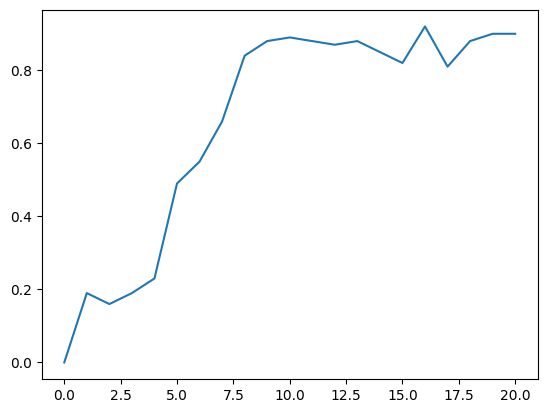

In [5]:
plt.plot(runner.win_rates)

# Out of Box sight change

## old captain IQL

In [12]:
class Runner_QMIX_SMAC:
    def __init__(self, args, number, seed):
        self.args = args
        self.number = number
        self.seed = seed
        # Set random seed
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        # Create env
        self.distribution_config = {
                        "n_units": self.args.N_agents,
                        "team_gen": {
                            "dist_type": "weighted_teams",
                            "unit_types": ["marine", "marauder", "medivac"],
                            "exception_unit_types": ["medivac"],
                            "weights": [1, 0, 0],
                            "observe": True,
                        },
                        "start_positions": {
                            "dist_type": "surrounded_and_reflect",
                            "p": 0.5,
                            "map_x": 32,
                            "map_y": 32,
                        },
                        "n_enemies": self.args.N_agents,
                    }
        self.env = StarCraftCapabilityEnvWrapper(
                    capability_config=self.distribution_config,
                    map_name="10gen_terran",
                    debug=False,
                    conic_fov=False,
                    obs_own_pos=True,
                    use_unit_ranges=False,
                    min_attack_range=2,
                    seed = self.seed)
        self.env_info = self.env.get_env_info()
        self.args.N = self.env_info["n_agents"]  # The number of agents
        self.args.obs_dim = self.env_info["obs_shape"]  # The dimensions of an agent's observation space
        self.args.state_dim = self.env_info["state_shape"]  # The dimensions of global state space
        self.args.action_dim = self.env_info["n_actions"]  # The dimensions of an agent's action space
        self.args.episode_limit = self.env_info["episode_limit"]  # Maximum number of steps per episode
        print("number of agents={}".format(self.args.N))
        print("obs_dim={}".format(self.args.obs_dim))
        print("state_dim={}".format(self.args.state_dim))
        print("action_dim={}".format(self.args.action_dim))
        print("episode_limit={}".format(self.args.episode_limit))

        # Create N agents
        self.agent_n = QMIX_SMAC(self.args)
        self.replay_buffer = ReplayBuffer(self.args)
        self.Captain = captain.Agent(state_size=self.args.obs_dim, action_size=3 ,eps_start=1.0,
                                      eps_end=0.05, eps_decay=0.998, BUFFER_SIZE = int(1e5),
                                        BATCH_SIZE = 64, GAMMA = 0.99, TAU = 1e-3, LR = 5e-4, UPDATE_EVERY = 4)

        # Create a tensorboard
        
        
        self.epsilon = self.args.epsilon  # Initialize the epsilon
        self.kill_sight_reward_ratio = self.args.kill_sight_reward_ratio
        self.win_rates = []  # Record the win rates
        self.total_steps = 0
        self.captain_action_history = []
        self.reward_list = []
        self.episode_reward_list = []
        self.captain_reward_list = []
        if self.args.use_reward_norm:
            print("------use reward norm------")
            self.reward_norm = Normalization(shape=1)

    def run(self, ):
        evaluate_num = -1  # Record the number of evaluations
        while self.total_steps < self.args.max_train_steps:
            if self.total_steps // self.args.evaluate_freq > evaluate_num:
                self.evaluate_policy()  # Evaluate the policy every 'evaluate_freq' steps
                evaluate_num += 1

            _, _, episode_steps = self.run_episode_smac(evaluate=False)  # Run an episode


            self.total_steps += episode_steps

            if self.replay_buffer.current_size >= self.args.batch_size:
                self.agent_n.train(self.replay_buffer, self.total_steps)  # Training

        self.evaluate_policy()
        self.env.close()

    def evaluate_policy(self, ):
        win_times = 0
        evaluate_reward = 0
        for _ in range(self.args.evaluate_times):
            win_tag, episode_reward, _ = self.run_episode_smac(evaluate=True)
            if win_tag:
                win_times += 1
            evaluate_reward += episode_reward

        win_rate = win_times / self.args.evaluate_times
        evaluate_reward = evaluate_reward / self.args.evaluate_times
        self.win_rates.append(win_rate)
        print("total_steps:{} \t win_rate:{} \t evaluate_reward:{}".format(self.total_steps, win_rate, evaluate_reward))
        # Save the win rates
        # np.save('./data_train/{}_env_{}_number_{}_seed_{}.npy'.format(self.args.algorithm, self.env_name, self.number, self.seed), np.array(self.win_rates))

    def run_episode_smac(self, evaluate=False):
        win_tag = False
        episode_reward = 0
        self.env.reset()
        if self.args.use_rnn:  # If use RNN, before the beginning of each episode，reset the rnn_hidden of the Q network.
            self.agent_n.eval_Q_net.rnn_hidden = None
        last_onehot_a_n = np.zeros((self.args.N, self.args.action_dim))  # Last actions of N agents(one-hot)
        for episode_step in range(self.args.episode_limit):
            obs_n = self.env.get_obs()  # obs_n.shape=(N,obs_dim)
            values = self.Captain.act(obs_n)
            self.captain_action_history.append(values)
            self.env.change_unit_capability_range(values)       # Captian changes sights and onw we have new obs
            obs_n = self.env.get_obs()  # obs_n.shape=(N,obs_dim)
            s = self.env.get_state()  # s.shape=(state_dim,)
            avail_a_n = self.env.get_avail_actions()  # Get available actions of N agents, avail_a_n.shape=(N,action_dim)
            epsilon = 0 if evaluate else self.epsilon
            a_n = self.agent_n.choose_action(obs_n, last_onehot_a_n, avail_a_n, epsilon)
            last_onehot_a_n = np.eye(self.args.action_dim)[a_n]  # Convert actions to one-hot vectors
            r, done, info = self.env.step(a_n)  # Take a step
            self.reward_list.append(r)
            ########################### captain ###########################
            
            for i in range(self.args.N):    # set dead soldier sight to default 9  
                if obs_n[i][0] == 0.0:  # health
                    self.env.visions[i] = 8.99
            new_obs_n = self.env.get_obs()                   
            captain_reward = r + (9*self.args.N-self.env.visions.sum())/self.kill_sight_reward_ratio  # captain reward  ##### CHANGE HERE ####
            self.captain_reward_list.append(captain_reward)
            
            ########################### captain ###########################
            win_tag = True if done and 'battle_won' in info and info['battle_won'] else False
            episode_reward += r

            if not evaluate:
                if self.args.use_reward_norm:
                    r = self.reward_norm(r)
                """"
                    When dead or win or reaching the episode_limit, done will be Ture, we need to distinguish them;
                    dw means dead or win,there is no next state s';
                    but when reaching the max_episode_steps,there is a next state s' actually.
                """
                if done and episode_step + 1 != self.args.episode_limit:
                    dw = True
                else:
                    dw = False

                # Store the transition
                self.replay_buffer.store_transition(episode_step, obs_n, s, avail_a_n, last_onehot_a_n, a_n, r, dw)
                # Decay the epsilon
                self.epsilon = self.epsilon - self.args.epsilon_decay if self.epsilon - self.args.epsilon_decay > self.args.epsilon_min else self.args.epsilon_min
                values = [int((value-9))/3+1 for value in values]
                self.Captain.step(obs_n, values, captain_reward, new_obs_n, done)       # Captain experience replay

            if done:
                break
        
        self.Captain.decay_epsilon()
        if not evaluate:
            # An episode is over, store obs_n, s and avail_a_n in the last step
            obs_n = self.env.get_obs()
            s = self.env.get_state()
            avail_a_n = self.env.get_avail_actions()
            self.replay_buffer.store_last_step(episode_step + 1, obs_n, s, avail_a_n)
        self.episode_reward_list.append(episode_reward)
        return win_tag, episode_reward, episode_step + 1
    def plot(self):
        self.captain_action_history = np.array(self.captain_action_history).reshape(self.args.N,-1)
        self.reward_list = np.array(self.reward_list)
        self.episode_reward_list = np.array(self.episode_reward_list)
        self.captain_reward_list = np.array(self.captain_reward_list)
        plt.plot(moving_average(self.reward_list, 5000))
        plt.title('reward list')
        plt.figure()
        plt.plot(moving_average(self.episode_reward_list, 1000))
        plt.title('episode_reward listward list')
        plt.figure()
        plt.plot(moving_average(self.captain_reward_list, 5000))
        plt.title('captain reward list')
        plt.figure()
        for i in range(self.args.N):
            plt.plot(moving_average(self.captain_action_history[i], 1000));
        plt.title('captain action list')





## new captain QMIX


In [2]:
class Runner_QMIX_SMAC:
    def __init__(self, args, number, seed):
        self.args = args
        self.number = number
        self.seed = seed
        # Set random seed
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        # Create env
        self.distribution_config = {
                        "n_units": self.args.N_agents,
                        "team_gen": {
                            "dist_type": "weighted_teams",
                            "unit_types": ["marine", "marauder", "medivac"],
                            "exception_unit_types": ["medivac"],
                            "weights": [1, 0, 0],
                            "observe": True,
                        },
                        "start_positions": {
                            "dist_type": "surrounded_and_reflect",
                            "p": 0.5,
                            "map_x": 32,
                            "map_y": 32,
                        },
                        "n_enemies": self.args.N_agents,
                    }
        self.env = StarCraftCapabilityEnvWrapper(
                    capability_config=self.distribution_config,
                    map_name="10gen_terran",
                    debug=False,
                    conic_fov=False,
                    obs_own_pos=True,
                    use_unit_ranges=False,
                    min_attack_range=2,
                    seed = self.seed)
        self.env_info = self.env.get_env_info()
        self.args.N = self.env_info["n_agents"]  # The number of agents
        self.args.obs_dim = self.env_info["obs_shape"]  # The dimensions of an agent's observation space
        self.args.state_dim = self.env_info["state_shape"]  # The dimensions of global state space
        self.captain_action_dim = 3  # The dimensions of an captain's action space
        self.args.action_dim = self.env_info["n_actions"]  # The dimensions of an agent's action space
        self.args.episode_limit = self.env_info["episode_limit"]  # Maximum number of steps per episode
        print("number of agents={}".format(self.args.N))
        print("obs_dim={}".format(self.args.obs_dim))
        print("state_dim={}".format(self.args.state_dim))
        print("action_dim={}".format(self.args.action_dim))
        print("episode_limit={}".format(self.args.episode_limit))

        # Create N agents
        self.agent_n = QMIX_SMAC(self.args)
        self.replay_buffer = ReplayBuffer(self.args)
        # Create Captain
        self.captain = QMIX_SMAC(self.args, captain= True)
        self.captain.action_dim = self.captain_action_dim
        self.captain.action_dim = self.captain_action_dim
        self.captain_replay_buffer = ReplayBuffer(self.args, captain= True)
        self.captain_avail_a_n = np.ones((self.args.N, self.captain_action_dim))

        # Create a tensorboard
        
        
        self.epsilon = self.args.epsilon  # Initialize the epsilon
        self.kill_sight_reward_ratio = self.args.kill_sight_reward_ratio
        self.win_rates = []  # Record the win rates
        self.total_steps = 0
        self.captain_action_history = []
        self.reward_list = []
        self.episode_reward_list = []
        self.captain_reward_list = []
        if self.args.use_reward_norm:
            print("------use reward norm------")
            self.reward_norm = Normalization(shape=1)

    def run(self, ):
        evaluate_num = -1  # Record the number of evaluations
        while self.total_steps < self.args.max_train_steps:
            if self.total_steps // self.args.evaluate_freq > evaluate_num:
                self.evaluate_policy()  # Evaluate the policy every 'evaluate_freq' steps
                evaluate_num += 1

            _, _, episode_steps = self.run_episode_smac(evaluate=False)  # Run an episode


            self.total_steps += episode_steps

            if self.replay_buffer.current_size >= self.args.batch_size:
                self.agent_n.train(self.replay_buffer, self.total_steps)  # Training
                self.captain.train(self.captain_replay_buffer, self.total_steps)

        self.evaluate_policy()
        self.env.close()

    def evaluate_policy(self, ):
        win_times = 0
        evaluate_reward = 0
        for _ in range(self.args.evaluate_times):
            win_tag, episode_reward, _ = self.run_episode_smac(evaluate=True)
            if win_tag:
                win_times += 1
            evaluate_reward += episode_reward

        win_rate = win_times / self.args.evaluate_times
        evaluate_reward = evaluate_reward / self.args.evaluate_times
        self.win_rates.append(win_rate)
        print("total_steps:{} \t win_rate:{} \t evaluate_reward:{}".format(self.total_steps, win_rate, evaluate_reward))
       
        # Save the win rates
        np.save('./data_train/{}_env_{}m_number_{}_seed_{}.npy'.format(self.args.algorithm, self.distribution_config["team_gen"]["n_units"], self.number, self.seed), np.array(self.win_rates))

    def run_episode_smac(self, evaluate=False):
        win_tag = False
        episode_reward = 0
        self.env.reset()
        if self.args.use_rnn:  # If use RNN, before the beginning of each episode，reset the rnn_hidden of the Q network.
            self.agent_n.eval_Q_net.rnn_hidden = None
        last_onehot_a_n = np.zeros((self.args.N, self.args.action_dim))  # Last actions of N agents(one-hot)
        captain_last_onehot_a_n = np.zeros((self.args.N, self.captain_action_dim))  # Last actions of N agents(one-hot)
        captian_avail_a_n = self.captain_avail_a_n  # Last actions of N agents(one-hot)
        epsilon = 0 if evaluate else self.epsilon
        for episode_step in range(self.args.episode_limit):
            obs_n = self.env.get_obs()  # obs_n.shape=(N,obs_dim)
            one_hot_sights = self.captain.choose_action(obs_n, captain_last_onehot_a_n, captian_avail_a_n, epsilon)
            values = (np.array(one_hot_sights)-1)*3+9
            self.captain_action_history.append(values)
            self.env.change_unit_capability_range(values)       # Captian changes sights and onw we have new obs
            obs_n = self.env.get_obs()  # obs_n.shape=(N,obs_dim)
            s = self.env.get_state()  # s.shape=(state_dim,)
            avail_a_n = self.env.get_avail_actions()  # Get available actions of N agents, avail_a_n.shape=(N,action_dim)
            a_n = self.agent_n.choose_action(obs_n, last_onehot_a_n, avail_a_n, epsilon)
            last_onehot_a_n = np.eye(self.args.action_dim)[a_n]  # Convert actions to one-hot vectors
            r, done, info = self.env.step(a_n)  # Take a step
            self.reward_list.append(r)
            
            ########################### captain ###########################
            
            for i in range(self.args.N):    # set dead soldier sight to default 9  
                if obs_n[i][0] == 0.0:  # health
                    self.env.visions[i] = 8.99
            captain_reward = r + (9*self.args.N-self.env.visions.sum())/self.kill_sight_reward_ratio  # captain reward  ##### CHANGE HERE #####
            self.captain_reward_list.append(captain_reward)
            
            ########################### captain ###########################
            win_tag = True if done and 'battle_won' in info and info['battle_won'] else False
            episode_reward += r

            if not evaluate:
                if self.args.use_reward_norm:
                    r = self.reward_norm(r)
                """"
                    When dead or win or reaching the episode_limit, done will be Ture, we need to distinguish them;
                    dw means dead or win,there is no next state s';
                    but when reaching the max_episode_steps,there is a next state s' actually.
                """
                if done and episode_step + 1 != self.args.episode_limit:
                    dw = True
                else:
                    dw = False

                # Store the transition
                self.replay_buffer.store_transition(episode_step, obs_n, s, avail_a_n, last_onehot_a_n, a_n, r, dw)
                self.captain_replay_buffer.store_transition(episode_step, obs_n, s, self.captain_avail_a_n, captain_last_onehot_a_n,
                                                             one_hot_sights, captain_reward, dw)
                # Decay the epsilon
                self.epsilon = self.epsilon - self.args.epsilon_decay if self.epsilon - self.args.epsilon_decay > self.args.epsilon_min else self.args.epsilon_min

            if done:
                break
        
        if not evaluate:
            # An episode is over, store obs_n, s and avail_a_n in the last step
            obs_n = self.env.get_obs()
            s = self.env.get_state()
            avail_a_n = self.env.get_avail_actions()
            self.replay_buffer.store_last_step(episode_step + 1, obs_n, s, avail_a_n)
            self.captain_replay_buffer.store_last_step(episode_step + 1, obs_n, s, self.captain_avail_a_n)
        self.episode_reward_list.append(episode_reward)
        return win_tag, episode_reward, episode_step + 1
    def plot(self):
        self.captain_action_history = np.array(self.captain_action_history).reshape(self.args.N,-1)
        self.reward_list = np.array(self.reward_list)
        self.episode_reward_list = np.array(self.episode_reward_list)
        self.captain_reward_list = np.array(self.captain_reward_list)
        plt.plot(self.win_rates)
        plt.title('Win Rate')
        plt.figure()
        plt.plot(moving_average(self.reward_list, 5000))
        plt.title('reward list')
        plt.figure()
        plt.plot(moving_average(self.episode_reward_list, 1000))
        plt.title('episode_reward listward list')
        plt.figure()
        plt.plot(moving_average(self.captain_reward_list, 5000))
        plt.title('captain reward list')
        plt.figure()
        for i in range(self.args.N):
            plt.plot(moving_average(self.captain_action_history[i], 1000));
        plt.title('captain action list')





In [ ]:
max_train_steps = int(1e3)
evaluate_freq = max_train_steps//20
epsilon_decay_steps = max_train_steps*1//5

parser = argparse.ArgumentParser("Hyperparameter Setting for QMIX and VDN in SMAC environment")
parser.add_argument("--max_train_steps", type=int, default=max_train_steps, help=" Maximum number of training steps")
parser.add_argument("--evaluate_freq", type=float, default=evaluate_freq, help="Evaluate the policy every 'evaluate_freq' steps")
parser.add_argument("--evaluate_times", type=float, default=1, help="Evaluate times")
parser.add_argument("--save_freq", type=int, default=int(1e5), help="Save frequency")

parser.add_argument("--algorithm", type=str, default="QMIX", help="QMIX or VDN")
parser.add_argument("--epsilon", type=float, default=1.0, help="Initial epsilon")
parser.add_argument("--epsilon_decay_steps", type=float, default=epsilon_decay_steps, help="How many steps before the epsilon decays to the minimum")
parser.add_argument("--epsilon_min", type=float, default=0.05, help="Minimum epsilon")
parser.add_argument("--buffer_size", type=int, default=5000, help="The capacity of the replay buffer")
parser.add_argument("--batch_size", type=int, default=32, help="Batch size (the number of episodes)")
parser.add_argument("--lr", type=float, default=5e-4, help="Learning rate")
parser.add_argument("--gamma", type=float, default=0.99, help="Discount factor")
parser.add_argument("--qmix_hidden_dim", type=int, default=32, help="The dimension of the hidden layer of the QMIX network")
parser.add_argument("--hyper_hidden_dim", type=int, default=64, help="The dimension of the hidden layer of the hyper-network")
parser.add_argument("--hyper_layers_num", type=int, default=1, help="The number of layers of hyper-network")
parser.add_argument("--rnn_hidden_dim", type=int, default=64, help="The dimension of the hidden layer of RNN")
parser.add_argument("--mlp_hidden_dim", type=int, default=64, help="The dimension of the hidden layer of MLP")
parser.add_argument("--use_rnn", type=bool, default=True, help="Whether to use RNN")
parser.add_argument("--use_orthogonal_init", type=bool, default=True, help="Orthogonal initialization")
parser.add_argument("--use_grad_clip", type=bool, default=True, help="Gradient clip")
parser.add_argument("--use_lr_decay", type=bool, default=False, help="use lr decay")
parser.add_argument("--use_RMS", type=bool, default=False, help="Whether to use RMS,if False, we will use Adam")
parser.add_argument("--add_last_action", type=bool, default=True, help="Whether to add last actions into the observation")
parser.add_argument("--add_agent_id", type=bool, default=False, help="Whether to add agent id into the observation")
parser.add_argument("--use_double_q", type=bool, default=True, help="Whether to use double q-learning")
parser.add_argument("--use_reward_norm", type=bool, default=False, help="Whether to use reward normalization")
parser.add_argument("--use_hard_update", type=bool, default=True, help="Whether to use hard update")
parser.add_argument("--target_update_freq", type=int, default=200, help="Update frequency of the target network")
parser.add_argument("--tau", type=int, default=0.005, help="If use soft update")
parser.add_argument("--kill_sight_reward_ratio", type=int, default=100, help="ratio of sight change penalty to state reward")
parser.add_argument("--N_agents", type=int, default=10, help="Number of agents for a team")
sys.argv=['']
args = parser.parse_args()
args.epsilon_decay = (args.epsilon - args.epsilon_min) / args.epsilon_decay_steps


runner = Runner_QMIX_SMAC(args, number=1, seed=0)
runner.run()

### qq 5e5 10m ratio 100

In [4]:
max_train_steps = int(5e5)
evaluate_freq = max_train_steps//20
epsilon_decay_steps = max_train_steps*1//5

parser = argparse.ArgumentParser("Hyperparameter Setting for QMIX and VDN in SMAC environment")
parser.add_argument("--max_train_steps", type=int, default=max_train_steps, help=" Maximum number of training steps")
parser.add_argument("--evaluate_freq", type=float, default=evaluate_freq, help="Evaluate the policy every 'evaluate_freq' steps")
parser.add_argument("--evaluate_times", type=float, default=100, help="Evaluate times")
parser.add_argument("--save_freq", type=int, default=int(1e5), help="Save frequency")

parser.add_argument("--algorithm", type=str, default="QMIX", help="QMIX or VDN")
parser.add_argument("--epsilon", type=float, default=1.0, help="Initial epsilon")
parser.add_argument("--epsilon_decay_steps", type=float, default=epsilon_decay_steps, help="How many steps before the epsilon decays to the minimum")
parser.add_argument("--epsilon_min", type=float, default=0.05, help="Minimum epsilon")
parser.add_argument("--buffer_size", type=int, default=5000, help="The capacity of the replay buffer")
parser.add_argument("--batch_size", type=int, default=32, help="Batch size (the number of episodes)")
parser.add_argument("--lr", type=float, default=5e-4, help="Learning rate")
parser.add_argument("--gamma", type=float, default=0.99, help="Discount factor")
parser.add_argument("--qmix_hidden_dim", type=int, default=32, help="The dimension of the hidden layer of the QMIX network")
parser.add_argument("--hyper_hidden_dim", type=int, default=64, help="The dimension of the hidden layer of the hyper-network")
parser.add_argument("--hyper_layers_num", type=int, default=1, help="The number of layers of hyper-network")
parser.add_argument("--rnn_hidden_dim", type=int, default=64, help="The dimension of the hidden layer of RNN")
parser.add_argument("--mlp_hidden_dim", type=int, default=64, help="The dimension of the hidden layer of MLP")
parser.add_argument("--use_rnn", type=bool, default=True, help="Whether to use RNN")
parser.add_argument("--use_orthogonal_init", type=bool, default=True, help="Orthogonal initialization")
parser.add_argument("--use_grad_clip", type=bool, default=True, help="Gradient clip")
parser.add_argument("--use_lr_decay", type=bool, default=False, help="use lr decay")
parser.add_argument("--use_RMS", type=bool, default=False, help="Whether to use RMS,if False, we will use Adam")
parser.add_argument("--add_last_action", type=bool, default=True, help="Whether to add last actions into the observation")
parser.add_argument("--add_agent_id", type=bool, default=False, help="Whether to add agent id into the observation")
parser.add_argument("--use_double_q", type=bool, default=True, help="Whether to use double q-learning")
parser.add_argument("--use_reward_norm", type=bool, default=False, help="Whether to use reward normalization")
parser.add_argument("--use_hard_update", type=bool, default=True, help="Whether to use hard update")
parser.add_argument("--target_update_freq", type=int, default=200, help="Update frequency of the target network")
parser.add_argument("--tau", type=int, default=0.005, help="If use soft update")
parser.add_argument("--kill_sight_reward_ratio", type=int, default=100, help="ratio of sight change penalty to state reward")
parser.add_argument("--N_agents", type=int, default=10, help="Number of agents for a team")
sys.argv=['']
args = parser.parse_args()
args.epsilon_decay = (args.epsilon - args.epsilon_min) / args.epsilon_decay_steps


runner = Runner_QMIX_SMAC(args, number=1, seed=0)
runner.run()

INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 14819 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-otuw99rm\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50


number of agents=10
obs_dim=162
state_dim=290
action_dim=16
episode_limit=200
------add last action------
------add agent id------
------use RNN------
------use_orthogonal_init------
------use_orthogonal_init------
------algorithm: QMIX------
hyper_layers_num=1
hyper_layers_num=1
------optimizer: Adam------
------add last action------
------add agent id------
------use MLP------
------use_orthogonal_init------
------use_orthogonal_init------
------algorithm: QMIX------
hyper_layers_num=1
hyper_layers_num=1
------optimizer: Adam------


INFO:absl:Connecting to: ws://127.0.0.1:14819/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:14819/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:14819/sc2api, attempt: 2, running: True


total_steps:0 	 win_rate:0.0 	 evaluate_reward:7.272000000000002
total_steps:25026 	 win_rate:0.12 	 evaluate_reward:9.074666666666666
total_steps:50018 	 win_rate:0.02 	 evaluate_reward:6.510400000000001


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 14841 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-13_tf72s\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:14841/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:14841/sc2api, attempt: 1, running: True


total_steps:75003 	 win_rate:0.02 	 evaluate_reward:7.365333333333337
total_steps:100028 	 win_rate:0.17 	 evaluate_reward:9.221599999999997


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 14882 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-b01x2nty\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:14882/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:14882/sc2api, attempt: 1, running: True


total_steps:125004 	 win_rate:0.22 	 evaluate_reward:10.795466666666668
total_steps:150020 	 win_rate:0.46 	 evaluate_reward:14.662666666666665


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 14905 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-ex2iwx6y\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:14905/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:14905/sc2api, attempt: 1, running: True


total_steps:175004 	 win_rate:0.49 	 evaluate_reward:15.282133333333334
total_steps:200033 	 win_rate:0.68 	 evaluate_reward:16.918933333333335


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 6288 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-b3p8997k\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:6288/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:6288/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:6288/sc2api, attempt: 2, running: True


total_steps:225022 	 win_rate:0.48 	 evaluate_reward:14.969866666666666
total_steps:250009 	 win_rate:0.66 	 evaluate_reward:16.87226666666666


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 11627 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-cc7dgot1\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:11627/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:11627/sc2api, attempt: 1, running: True


total_steps:275008 	 win_rate:0.7 	 evaluate_reward:17.2256
total_steps:300026 	 win_rate:0.74 	 evaluate_reward:17.578666666666667
total_steps:325016 	 win_rate:0.7 	 evaluate_reward:17.176


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 4621 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-7we3fjsv\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:4621/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:4621/sc2api, attempt: 1, running: True


total_steps:350012 	 win_rate:0.78 	 evaluate_reward:17.87866666666667
total_steps:375043 	 win_rate:0.81 	 evaluate_reward:18.110400000000002


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 12478 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-fdcfwv65\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:12478/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:12478/sc2api, attempt: 1, running: True


total_steps:400048 	 win_rate:0.74 	 evaluate_reward:17.725066666666663
total_steps:425004 	 win_rate:0.61 	 evaluate_reward:16.39973333333333


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 6430 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-33pbvfyc\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:6430/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:6430/sc2api, attempt: 1, running: True


total_steps:450014 	 win_rate:0.76 	 evaluate_reward:17.911466666666666
total_steps:475003 	 win_rate:0.64 	 evaluate_reward:16.541066666666666


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 13787 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-a2b4sdrx\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:13787/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:13787/sc2api, attempt: 1, running: True
INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1


total_steps:500024 	 win_rate:0.67 	 evaluate_reward:16.726133333333333


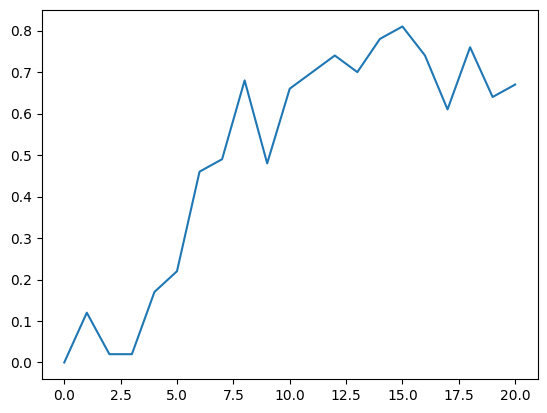

In [7]:
plt.plot(runner.win_rates)

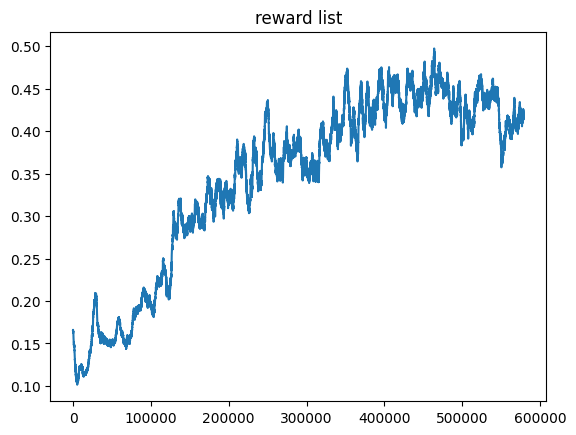

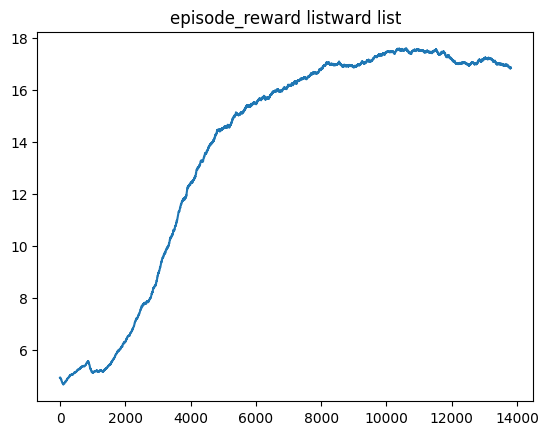

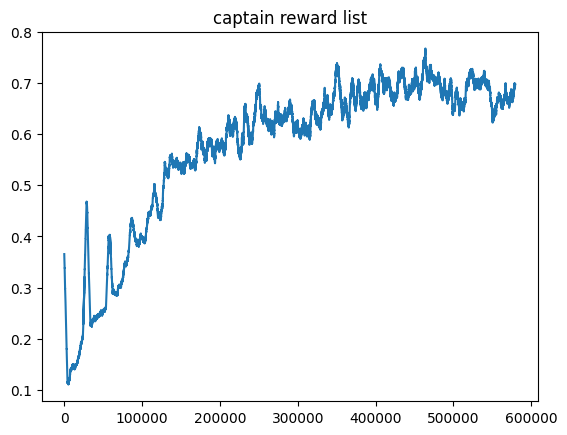

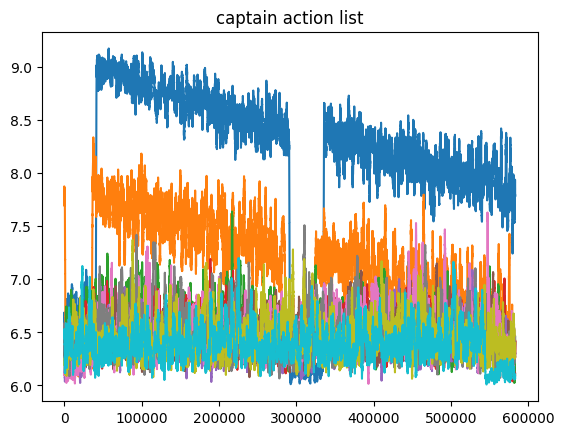

In [6]:
runner.plot()

### qq 5e5 5m ratio 100

INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 3922 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-t9qelvcb\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:3922/sc2api, attempt: 0, running: True


number of agents=5
obs_dim=82
state_dim=120
action_dim=11
episode_limit=200
------add last action------
------add agent id------
------use RNN------
------use_orthogonal_init------
------use_orthogonal_init------
------algorithm: QMIX------
hyper_layers_num=1
hyper_layers_num=1
------optimizer: Adam------
------add last action------
------add agent id------
------use MLP------
------use_orthogonal_init------
------use_orthogonal_init------
------algorithm: QMIX------
hyper_layers_num=1
hyper_layers_num=1
------optimizer: Adam------


INFO:absl:Connecting to: ws://127.0.0.1:3922/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:3922/sc2api, attempt: 2, running: True


total_steps:0 	 win_rate:0.0 	 evaluate_reward:2.303999999999999
total_steps:25013 	 win_rate:0.16 	 evaluate_reward:8.325052631578943
total_steps:50031 	 win_rate:0.13 	 evaluate_reward:8.229473684210522


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 14211 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-6wa2q_8a\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:14211/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:14211/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:14211/sc2api, attempt: 2, running: True


total_steps:75000 	 win_rate:0.39 	 evaluate_reward:12.642947368421051
total_steps:100037 	 win_rate:0.29 	 evaluate_reward:11.50526315789474


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 8471 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-z8vyqt7f\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:8471/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:8471/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:8471/sc2api, attempt: 2, running: True


total_steps:125009 	 win_rate:0.47 	 evaluate_reward:14.171789473684212
total_steps:150015 	 win_rate:0.55 	 evaluate_reward:14.997894736842111


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 1566 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-5t7wt9s3\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:1566/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:1566/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:1566/sc2api, attempt: 2, running: True


total_steps:175024 	 win_rate:0.71 	 evaluate_reward:16.683368421052634
total_steps:200021 	 win_rate:0.79 	 evaluate_reward:17.72842105263158


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 8194 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-9uya8vru\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:8194/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:8194/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:8194/sc2api, attempt: 2, running: True


total_steps:225016 	 win_rate:0.78 	 evaluate_reward:17.391578947368426
total_steps:250009 	 win_rate:0.84 	 evaluate_reward:18.26821052631579
total_steps:275010 	 win_rate:0.87 	 evaluate_reward:18.391157894736843


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 2198 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-uzg80v13\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:2198/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:2198/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:2198/sc2api, attempt: 2, running: True


total_steps:300021 	 win_rate:0.84 	 evaluate_reward:18.177684210526316
total_steps:325018 	 win_rate:0.78 	 evaluate_reward:17.328000000000003


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 9644 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-vopqauak\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:9644/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:9644/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:9644/sc2api, attempt: 2, running: True


total_steps:350047 	 win_rate:0.83 	 evaluate_reward:18.015157894736845
total_steps:375021 	 win_rate:0.68 	 evaluate_reward:16.380631578947373


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 3320 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-wh4fnssg\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:3320/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:3320/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:3320/sc2api, attempt: 2, running: True


total_steps:400025 	 win_rate:0.75 	 evaluate_reward:17.04673684210526
total_steps:425010 	 win_rate:0.86 	 evaluate_reward:18.39284210526316
total_steps:450049 	 win_rate:0.86 	 evaluate_reward:18.35915789473684


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1
INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 12254 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-tm2fqsk0\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:12254/sc2api, attempt: 0, running: True
INFO:absl:Connecting to: ws://127.0.0.1:12254/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:12254/sc2api, attempt: 2, running: True


total_steps:475010 	 win_rate:0.88 	 evaluate_reward:18.626526315789473


INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1


total_steps:500002 	 win_rate:0.79 	 evaluate_reward:17.604631578947366


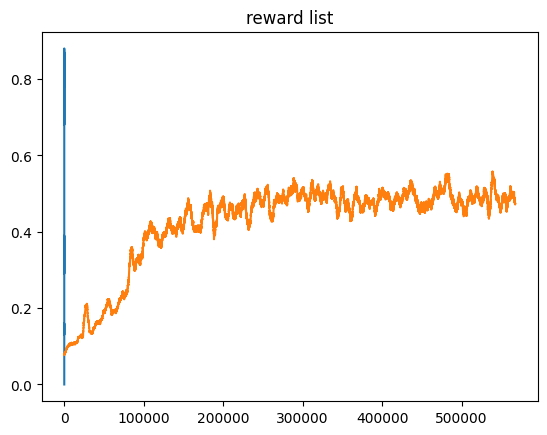

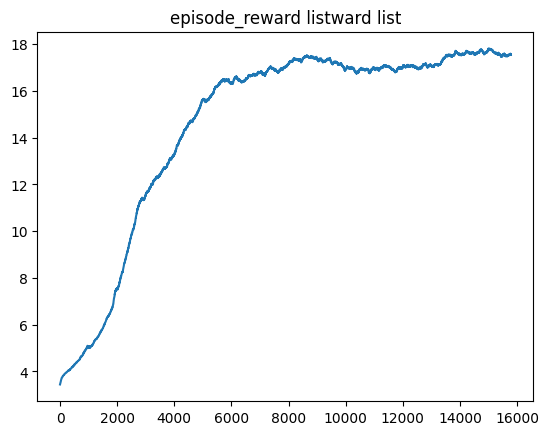

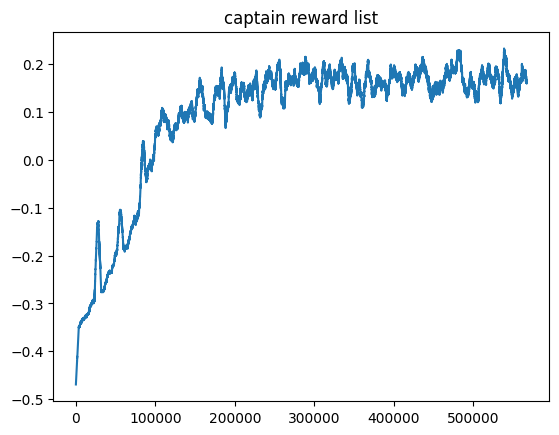

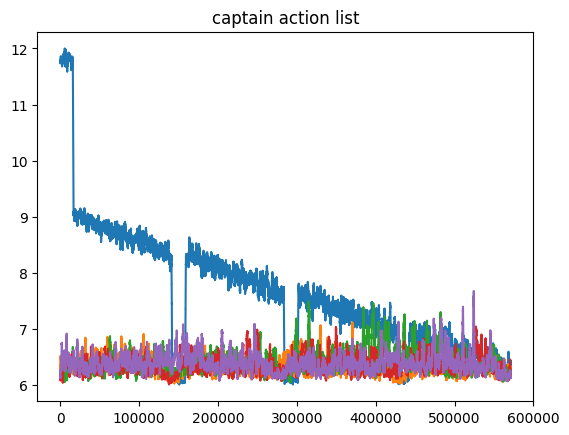

In [7]:
max_train_steps = int(5e5)
evaluate_freq = max_train_steps//20
epsilon_decay_steps = max_train_steps*1//5

parser = argparse.ArgumentParser("Hyperparameter Setting for QMIX and VDN in SMAC environment")
parser.add_argument("--max_train_steps", type=int, default=max_train_steps, help=" Maximum number of training steps")
parser.add_argument("--evaluate_freq", type=float, default=evaluate_freq, help="Evaluate the policy every 'evaluate_freq' steps")
parser.add_argument("--evaluate_times", type=float, default=100, help="Evaluate times")
parser.add_argument("--save_freq", type=int, default=int(1e5), help="Save frequency")

parser.add_argument("--algorithm", type=str, default="QMIX", help="QMIX or VDN")
parser.add_argument("--epsilon", type=float, default=1.0, help="Initial epsilon")
parser.add_argument("--epsilon_decay_steps", type=float, default=epsilon_decay_steps, help="How many steps before the epsilon decays to the minimum")
parser.add_argument("--epsilon_min", type=float, default=0.05, help="Minimum epsilon")
parser.add_argument("--buffer_size", type=int, default=5000, help="The capacity of the replay buffer")
parser.add_argument("--batch_size", type=int, default=32, help="Batch size (the number of episodes)")
parser.add_argument("--lr", type=float, default=5e-4, help="Learning rate")
parser.add_argument("--gamma", type=float, default=0.99, help="Discount factor")
parser.add_argument("--qmix_hidden_dim", type=int, default=32, help="The dimension of the hidden layer of the QMIX network")
parser.add_argument("--hyper_hidden_dim", type=int, default=64, help="The dimension of the hidden layer of the hyper-network")
parser.add_argument("--hyper_layers_num", type=int, default=1, help="The number of layers of hyper-network")
parser.add_argument("--rnn_hidden_dim", type=int, default=64, help="The dimension of the hidden layer of RNN")
parser.add_argument("--mlp_hidden_dim", type=int, default=64, help="The dimension of the hidden layer of MLP")
parser.add_argument("--use_rnn", type=bool, default=True, help="Whether to use RNN")
parser.add_argument("--use_orthogonal_init", type=bool, default=True, help="Orthogonal initialization")
parser.add_argument("--use_grad_clip", type=bool, default=True, help="Gradient clip")
parser.add_argument("--use_lr_decay", type=bool, default=False, help="use lr decay")
parser.add_argument("--use_RMS", type=bool, default=False, help="Whether to use RMS,if False, we will use Adam")
parser.add_argument("--add_last_action", type=bool, default=True, help="Whether to add last actions into the observation")
parser.add_argument("--add_agent_id", type=bool, default=False, help="Whether to add agent id into the observation")
parser.add_argument("--use_double_q", type=bool, default=True, help="Whether to use double q-learning")
parser.add_argument("--use_reward_norm", type=bool, default=False, help="Whether to use reward normalization")
parser.add_argument("--use_hard_update", type=bool, default=True, help="Whether to use hard update")
parser.add_argument("--target_update_freq", type=int, default=200, help="Update frequency of the target network")
parser.add_argument("--tau", type=int, default=0.005, help="If use soft update")
parser.add_argument("--kill_sight_reward_ratio", type=int, default=100, help="ratio of sight change penalty to state reward")
parser.add_argument("--N_agents", type=int, default=5, help="Number of agents for a team")
sys.argv=['']
args = parser.parse_args()
args.epsilon_decay = (args.epsilon - args.epsilon_min) / args.epsilon_decay_steps


runner = Runner_QMIX_SMAC(args, number=1, seed=0)
runner.run()
runner.plot()

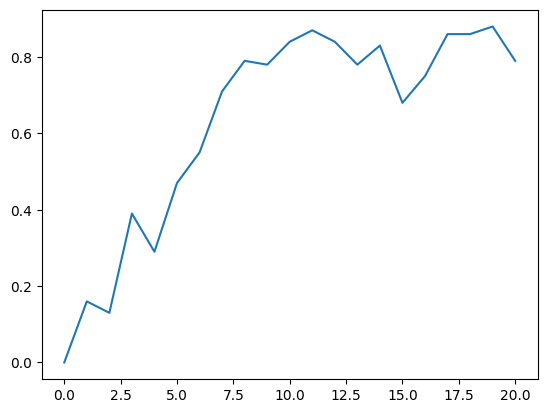

In [8]:
plt.plot(runner.win_rates)

## result

In [15]:
no_cap_12 = np.array([0, 0.09, 0.09, 0.09, 0.09, 0.17, 0.18, 0.39, 0.29, 0.69, 0.69, 0.71,
0.74, 0.81, 0.74, 0.79, 0.85, 0.82, 0.78, 0.83, 0.78])
no_cap_6 = np.array([0, 0.04, 0.01, 0.01, 0.0, 0.01, 0.03, 0.11, 0.13, 0.22, 0.32, 0.22, 0.3,
 0.44, 0.48, 0.49, 0.58, 0.56, 0.54, 0.63, 0.6])
cap = np.array([0, 0.12, 0.02, 0.02, 0.17, 0.22, 0.46, 0.49, 0.68, 0.48, 0.66, 0.7, 0.74, 
0.7, 0.78, 0.81, 0.74, 0.61, 0.76, 0.64, 0.67])



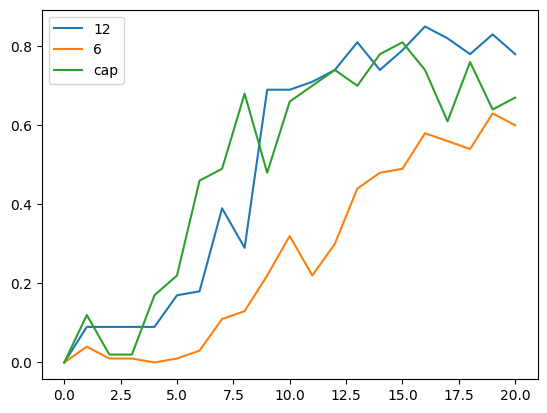

In [16]:
plt.plot(no_cap_12)
plt.plot(no_cap_6)
plt.plot(cap)
plt.legend(['12', '6', 'cap'])

In [8]:
nocap_12_5m = np.array([0, 0.19,0.16,0.19,0.23,0.49,0.55,0.66,0.84,0.88,0.89,0.88,
          0.87,0.88,0.85,0.82,0.92,0.81,0.88,0.9,0.9])
nocap_6_5m = np.array([0. , 0.09, 0.05, 0.04, 0.21, 0.25, 0.21, 0.3 , 0.32, 0.44, 0.51,
         0.46, 0.49, 0.55, 0.51, 0.49, 0.59, 0.54, 0.58, 0.62, 0.68])
cap_5m = np.array([0 ,0.16, 0.13, 0.39, 0.29, 0.47, 0.55, 0.71, 0.79, 0.78, 0.84, 0.87, 0.84, 
          0.78, 0.83, 0.68, 0.75, 0.86 ,0.86, 0.88, 0.79])


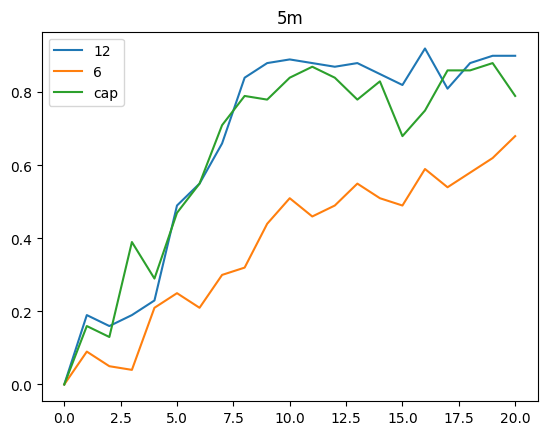

In [9]:
plt.plot(nocap_12_5m)
plt.plot(nocap_6_5m)
plt.plot(cap_5m)
plt.title('5m')
plt.legend(['12', '6', 'cap'])

# Modified

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from os import replace

from smac.env import StarCraft2Env
import numpy as np
from absl import logging
import time

from smacv2.env.starcraft2.wrapper import StarCraftCapabilityEnvWrapper

logging.set_verbosity(logging.DEBUG)

distribution_config = {
    "n_units": 3,
    "team_gen": {
        "dist_type": "weighted_teams",
        "unit_types": ["marine", "marauder", "medivac"],
        "exception_unit_types": ["medivac"],
        "weights": [1, 0, 0],
        "observe": True,
    },
    "start_positions": {
        "dist_type": "surrounded_and_reflect",
        "p": 0.5,
        "map_x": 32,
        "map_y": 32,
    },
    "n_enemies": 3,
}
env = StarCraftCapabilityEnvWrapper(
    capability_config=distribution_config,
    map_name="10gen_terran",
    debug=False,
    conic_fov=False,
    obs_own_pos=True,
    use_unit_ranges=True,
    min_attack_range=2,
)

env_info = env.get_env_info()

n_actions = env_info["n_actions"]
n_agents = env_info["n_agents"]

n_episodes = 5

print("Training episodes")
for e in range(n_episodes):
    env.reset()
    terminated = False
    episode_reward = 0

    while not terminated:
            obs = env.get_obs()
            state = env.get_state()
            # env.render()  # Uncomment for rendering

            actions = []
            for agent_id in range(n_agents):
                avail_actions = env.get_avail_agent_actions(agent_id)
                avail_actions_ind = np.nonzero(avail_actions)[0]
                action = np.random.choice(avail_actions_ind)
                actions.append(action)
            # tag = env.env.agents[i].tag
            # tags = [tag]
            # env._kill_units(tags)
            reward, terminated, _ = env.step(actions)
            # time.sleep(0.15)



INFO:absl:Launching SC2: C:/Program Files (x86)/StarCraft II\Versions/Base90136\SC2_x64.exe -listen 127.0.0.1 -port 14401 -dataDir C:/Program Files (x86)/StarCraft II\ -tempDir C:\Users\nimaz\AppData\Local\Temp\sc-696t6wml\ -displayMode 0 -windowwidth 1920 -windowheight 1200 -windowx 50 -windowy 50
INFO:absl:Connecting to: ws://127.0.0.1:14401/sc2api, attempt: 0, running: True


Training episodes


INFO:absl:Connecting to: ws://127.0.0.1:14401/sc2api, attempt: 1, running: True
INFO:absl:Connecting to: ws://127.0.0.1:14401/sc2api, attempt: 2, running: True
INFO:absl:Connecting to: ws://127.0.0.1:14401/sc2api, attempt: 3, running: True


In [2]:
env.close()

INFO:absl:Shutdown gracefully.
INFO:absl:Shutdown with return code: 1


# DQN Test

In [ ]:
env = StarCraft2Env(map_name="8m")
env_info = env.get_env_info()

n_actions = env_info["n_actions"]
n_agents = env_info["n_agents"]

env.reset()
terminated = False
episode_reward = 0

for tt in range(10):
    obs = env.get_obs()
    state = env.get_state()

    actions = []
    for agent_id in range(n_agents):
        avail_actions = env.get_avail_agent_actions(agent_id)
        print(avail_actions)
        a = env.get_obs()
        print(env.get_obs()[0].shape)
        break
        avail_actions_ind = np.nonzero(avail_actions)[0]
        action = np.random.choice(avail_actions_ind)
        actions.append(action)

    reward, terminated, _ = env.step(actions)
    episode_reward += reward

print("Total reward in episode = {}".format( episode_reward))



In [5]:
import gym
import captain_lunar
import numpy as np
from collections import deque, namedtuple

def dqn(n_episodes=2000, max_t=1000):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    env = gym.make("LunarLander-v2",continuous=True)

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        agent.decay_epsilon()
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

agent = captain_lunar.Agent(state_size=8, action_size=4,eps_start=1.0, eps_end=0.01, eps_decay=0.995,
              BUFFER_SIZE = int(1e5), BATCH_SIZE = 64, GAMMA = 0.99, TAU = 1e-3, LR = 5e-4, UPDATE_EVERY = 4)     
scores = dqn()

TypeError: __init__() got an unexpected keyword argument 'continuous'